In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
vocab_size = 18000
embedding_dim = 256
max_length = 120
filters = 64
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()

In [4]:
with open('racism.json', 'r') as file:
    data_racism = pd.read_json(file,lines=True)
with open('neither.json', 'r') as file:
    data_neither = pd.read_json(file,lines=True)
with open('sexism.json', 'r') as file:
    data_sexism = pd.read_json(file,lines=True)

In [5]:
labels_read = []
text_read = []
labels_read = list(data_racism['Annotation'])
text_read = list(data_racism['text'])
labels_read.extend(list(data_neither['Annotation']))
labels_read.extend(list(data_sexism['Annotation']))
text_read.extend(list(data_neither['text']))
text_read.extend(list(data_sexism['text']))

print(len(text_read))

16907


In [6]:
labels = list()
texts = list()
i = 0
for i in range(0,len(text_read)):
    labels.append(labels_read[i])
    texts.append(text_read[i])
# print(type(text_read[i]))
print(len(texts))
print(len(labels))

16907
16907


In [7]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_emoji = ''
    for char in text:
        if char not in emoji_list:
            no_emoji = no_emoji + char
        else:
            no_emoji = no_emoji + '<' + emoji.demojize(char) + '> '
    text = no_emoji
    
    text = re_sub(r"@\w+","<user>")
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct
    text = text.replace("  "," ")
    return text.lower()


In [8]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

In [9]:
print(set(labels))

{'sexism', 'none', 'racism'}


In [10]:
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2)
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))

13525
13525
3382
3382


In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

15073
13
120
18
120


In [12]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [13]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [14]:
def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 389s - loss: 0.7249 - acc: 0.7058 - val_loss: 0.6203 - val_acc: 0.7643
Epoch 2/10
13525/13525 - 167s - loss: 0.4915 - acc: 0.8163 - val_loss: 0.4847 - val_acc: 0.8040
Epoch 3/10
13525/13525 - 183s - loss: 0.4515 - acc: 0.8273 - val_loss: 0.4822 - val_acc: 0.8093
Epoch 4/10
13525/13525 - 266s - loss: 0.3697 - acc: 0.8634 - val_loss: 0.4709 - val_acc: 0.8220
Epoch 5/10
13525/13525 - 316s - loss: 0.3297 - acc: 0.8794 - val_loss: 0.4525 - val_acc: 0.8250
Epoch 6/10
13525/13525 - 330s - loss: 0.3013 - acc: 0.8878 - val_loss: 0.4846 - val_acc: 0.8220
Epoch 7/10
13525/13525 - 333s - loss: 0.2738 - acc: 0.9017 - val_loss: 0.4691 - val_acc: 0.8202
Epoch 8/10
13525/13525 - 331s - loss: 0.2558 - acc: 0.9081 - val_loss: 0.4822 - val_acc: 0.8137
Epoch 9/10
13525/13525 - 310s - loss: 0.2344 - acc: 0.9166 - val_loss: 0.4855 - val_acc: 0.8161
Epoch 10/10
13525/13525 - 310s - loss: 0.2182 - acc: 0.9237 - val_loss: 0.4869 - val_ac

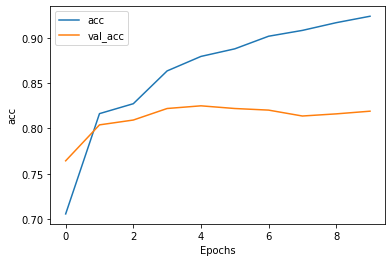

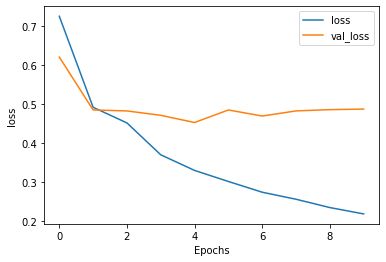

In [15]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.GRU(300),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=0.0006), metrics=['acc'])
# model2.summary()
num_epochs = 10
history2 = model2.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")